## Train custom instance segmentation model using Detectron2

**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output

Mounted at /content/drive


In [2]:
import gdown
!gdown 1vvuo_BP2R5grxCqpYovn2C0ApA0rXTWK
!jar xvf 'arcade_dataset_phase_1_with_val.zip'

Downloading...
From: https://drive.google.com/uc?id=1vvuo_BP2R5grxCqpYovn2C0ApA0rXTWK
To: /content/arcade_dataset_phase_1_with_val.zip
100% 380M/380M [00:01<00:00, 214MB/s]
  created: arcade_dataset_phase_1_with_val/
  created: arcade_dataset_phase_1_with_val/segmentation_dataset/
  created: arcade_dataset_phase_1_with_val/segmentation_dataset/train/
  created: arcade_dataset_phase_1_with_val/segmentation_dataset/train/annotations/
 inflated: arcade_dataset_phase_1_with_val/segmentation_dataset/train/annotations/train.json
  created: arcade_dataset_phase_1_with_val/segmentation_dataset/train/images/
extracted: arcade_dataset_phase_1_with_val/segmentation_dataset/train/images/1.png
extracted: arcade_dataset_phase_1_with_val/segmentation_dataset/train/images/10.png
extracted: arcade_dataset_phase_1_with_val/segmentation_dataset/train/images/100.png
 inflated: arcade_dataset_phase_1_with_val/segmentation_dataset/train/images/1000.png
extracted: arcade_dataset_phase_1_with_val/segmentation

**Install Detectron2**

In [3]:
#!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=8f3b9dc598b475fb1224786980b508cf5666a52622444a6d2395eba318f3bc1f
  S

**Check GPU**

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


**Import necessary libraries**

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Of course, our cells are mislabeled as Tie, Pizza, etc. Let us train on a custom dataset.

# Train on a custom dataset

**Download Dataset**

In [ ]:
%cp '/content/drive/MyDrive/Morshed/images.zip' '/content/train'
%cp '/content/drive/MyDrive/Morshed/train.json' '/content/train'
%cp '/content/drive/MyDrive/Morshed/val.zip' '/content/val'
%cp '/content/drive/MyDrive/Morshed/val.json' '/content/val'

In [ ]:
%cd /content/train
!jar xvf '/content/drive/MyDrive/Morshed/images.zip'
%cd /content/val
!jar xvf '/content/drive/MyDrive/Morshed/val.zip'

In [6]:
import json

def replace_duplicate_annotation_ids_v2(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extracting annotation IDs
    annotation_ids = [annotation['id'] for annotation in data['annotations']]

    # Create a set to track unique IDs and a dictionary for new IDs for duplicates
    unique_ids = set()
    new_id_map = {}

    # Current maximum ID
    max_id = max(annotation_ids)

    # Assign new IDs to annotations, ensuring no duplicates
    for annotation in data['annotations']:
        if annotation['id'] in unique_ids:
            # If duplicate, assign a new unique ID
            max_id += 1
            new_id_map[annotation['id']] = max_id
            annotation['id'] = max_id
        else:
            # If unique, add to the set of unique IDs
            unique_ids.add(annotation['id'])

    # Save the modified data back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file)

    return new_id_map



In [7]:
# Replace this with the path to your JSON file
file_path = '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/train/annotations/train.json'

# Execute the function to ensure no duplicate annotation IDs
new_id_map = replace_duplicate_annotation_ids_v2(file_path)

# The new_id_map variable will contain the mapping of old duplicate IDs to new unique IDs
print("Mapping of old duplicate IDs to new unique IDs:", new_id_map)

Mapping of old duplicate IDs to new unique IDs: {1: 1066, 2: 1067, 3: 1068, 4: 1069, 5: 1070, 6: 1071, 7: 1072, 8: 1073, 9: 1074, 10: 1075, 11: 1076, 12: 1077, 13: 1078, 14: 1079, 15: 1080, 16: 1081, 17: 1082, 18: 1083, 19: 1084, 20: 1085, 21: 1086, 22: 1087, 23: 1088, 24: 1089, 25: 1090, 26: 1091, 27: 1092, 28: 1093, 29: 1094, 30: 1095, 31: 1096, 32: 1097, 33: 1098, 34: 1099, 35: 1100, 36: 1101, 37: 1102, 38: 1103, 39: 1104, 40: 1105, 41: 1106, 42: 1107, 43: 1108, 44: 1109, 45: 1110, 46: 1111, 47: 1112, 48: 1113, 49: 1114, 50: 1115, 51: 1116, 52: 1117, 53: 1118, 54: 1119, 55: 1120, 56: 1121, 57: 1122, 58: 1123, 59: 1124, 60: 1125, 61: 1126, 62: 1127, 63: 1128, 64: 1129, 65: 1130, 66: 1131, 67: 1132, 68: 1133, 69: 1134, 70: 1135, 71: 1136, 72: 1137, 73: 1138, 74: 1139, 75: 1140, 76: 1141, 77: 1142, 78: 1143, 79: 1144, 80: 1145, 81: 1146, 82: 1147, 83: 1148, 84: 1149, 85: 1150, 86: 1151, 87: 1152, 88: 1153, 89: 1154, 90: 1155, 91: 1156, 92: 1157, 93: 1158, 94: 1159, 95: 1160, 96: 1161, 

In [ ]:
# Replace this with the path to your JSON file
file_path = '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/annotations/val.json'

# Execute the function to ensure no duplicate annotation IDs
new_id_map = replace_duplicate_annotation_ids_v2(file_path)

# The new_id_map variable will contain the mapping of old duplicate IDs to new unique IDs
print("Mapping of old duplicate IDs to new unique IDs:", new_id_map)

Mapping of old duplicate IDs to new unique IDs: {}


**Register Dataset**

Dataset must be in COCO format

In [ ]:
train_data = {
    'name' : 'arcade_stenosis_train',
    'annotation_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/train/annotations/train.json',
    'images_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/train/images'
}

val_data = {
    'name' : 'arcade_stenosis_val',
    'annotation_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/annotations/val.json',
    'images_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/images'
}

test_data = {
    'name' : 'arcade_stenosis_test',
    'annotation_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/annotations/val.json',
    'images_path': '/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/images'
}

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(train_data['name'], {}, train_data['annotation_path'], train_data['images_path'])
register_coco_instances(val_data['name'], {}, val_data['annotation_path'], val_data['images_path'])
#register_coco_instances(test_data['name'], {}, test_data['annotation_path'], test_data['images_path'])

**Extract metadata and catalog**

In [ ]:
train_metadata = MetadataCatalog.get(train_data['name'])
train_dataset_dicts = DatasetCatalog.get(train_data['name'])

[12/28 12:46:56 d2.data.datasets.coco]: Loaded 1000 images in COCO format from /content/arcade_dataset_phase_1_with_val/stenosis_dataset/train/annotations/train.json


In [ ]:
val_metadata = MetadataCatalog.get(val_data['name'])
val_dataset_dicts = DatasetCatalog.get(val_data['name'])


[12/28 12:46:57 d2.data.datasets.coco]: Loaded 200 images in COCO format from /content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/annotations/val.json


In [ ]:
test_metadata = MetadataCatalog.get(test_data['name'])
test_dataset_dicts = DatasetCatalog.get(test_data['name'])

[12/27 06:01:02 d2.data.datasets.coco]: Loaded 200 images in COCO format from /content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/annotations/val.json


**Visualize Random Sample**

In [ ]:
from matplotlib import pyplot as plt

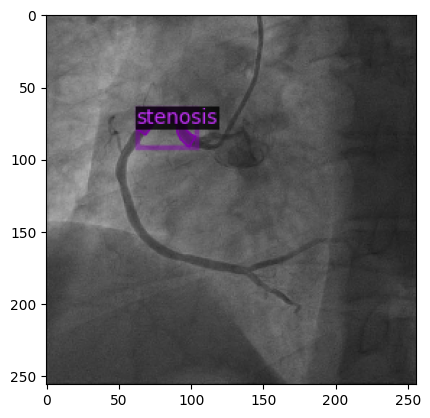

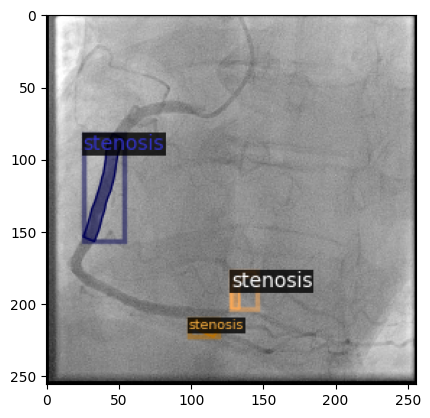

In [ ]:
# Visualize some random samples from train
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Train model from Model Zoo

https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md


In [ ]:
from detectron2.evaluation import DatasetEvaluators, COCOEvaluator
from detectron2.engine import DefaultTrainer

class evalTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        coco_evaluator = COCOEvaluator(dataset_name, output_dir=output_folder)

        evaluator_list = [coco_evaluator]

        return DatasetEvaluators(evaluator_list)

In [ ]:
#!rm -r /content/Output
!mkdir /content/Output

In [ ]:
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import DatasetEvaluators, COCOEvaluator
from detectron2.utils.events import EventWriter, get_event_storage

class EvalTrainer(DefaultTrainer):
    def __init__(self, cfg, patience=5):
        super().__init__(cfg)
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, output_dir=output_folder)

    def train_loop(self, start_iter: int, max_iter: int):
        assert self.model.training, "[EvalTrainer] model was changed to eval mode!"
        assert len(self.cfg.DATASETS.TEST), "[EvalTrainer] No test dataset is specified!"

        super().train_loop(start_iter, max_iter)

    def run_step(self):
        super().run_step()
        self._maybe_evaluate()

    def _maybe_evaluate(self):
        storage = get_event_storage()
        cur_iter = storage.iter

        # Perform evaluation at the end of each epoch and at the last iteration
        if (cur_iter + 1) % self.cfg.SOLVER.CHECKPOINT_PERIOD == 0 or (cur_iter + 1) == self.max_iter:
            results = self.test(self.cfg, self.model)
            val_loss = results['bbox']['AP']  # Assuming you want to monitor AP as a proxy for validation loss

            # Log the validation loss for Tensorboard
            storage.put_scalar("validation_loss", val_loss, smoothing_hint=False)
            print("********************THIS IS RUNNING****************************")

            # Print the validation loss
            print(f"Iteration {cur_iter + 1}: Validation Loss = {val_loss}")

            if val_loss > self.best_val_loss:
                self.best_val_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1

            if self.wait >= self.patience:
                print(f"Stopping training at iteration {cur_iter + 1}, no improvement for {self.patience} checkpoints")
                raise hooks.StopTraining()

    def test(self, cfg, model, evaluators=None):
        # Overriding the DefaultTrainer test method to return results
        if evaluators is None:
            evaluators = self.build_evaluator(cfg, cfg.DATASETS.TEST[0])
        return super().test(cfg, model, evaluators)


In [ ]:
from detectron2.engine.hooks import HookBase
import logging
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader, patience=5):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # Early stopping logic
        if mean_loss < self.best_val_loss:
            self.best_val_loss = mean_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Stopping training due to no improvement in validation loss")
                raise hooks.StopTraining()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class xEarlyStoppingTrainer(DefaultTrainer):
    def __init__(self, cfg, patience=5):
        self.patience = patience  # Set patience before calling super().__init__
        super().__init__(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        # Insert LossEvalHook with the correct reference to patience
        hooks.insert(-1, LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            ),
            patience=self.patience
        ))
        return hooks

In [ ]:
from detectron2.engine import DefaultTrainer
# from earlystopping import EarlyStoppingTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/Output" #output folder
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # load model configuration
cfg.DATASETS.TRAIN = (train_data['name'],) #Train dataset, must be passed a tuple
cfg.DATASETS.TEST = (val_data['name'],) #Val dataset, must be passed a tuple
cfg.DATALOADER.NUM_WORKERS = 2 #parallel processing workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize weights from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # batch_size
cfg.SOLVER.BASE_LR = 0.00025  # base lr
cfg.SOLVER.MAX_ITER = 250000    # num of iterations
cfg.SOLVER.STEPS = []        # learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # image size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # num of classes (without background)
cfg.SOLVER.CHECKPOINT_PERIOD = 2000 # checkpoint period
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   # set a custom testing threshold
cfg.TEST.EVAL_PERIOD = 50  # evaluate every 1000 iterations
patience_val = 60 # early stopping patience

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = xEarlyStoppingTrainer(cfg, patience = patience_val) #Create an instance of Trainer
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[12/28 12:47:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 165MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[12/28 12:47:56 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [12/28 12:48:00 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/content/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/content/detectron2/detectron2/engine/defaults.py", line 496, in run_step
    self._trainer.run_step()
  File "/content/detectron2/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/content/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 167, in forward
    _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wra

RuntimeError: ignored

Save the config file, for potential future use

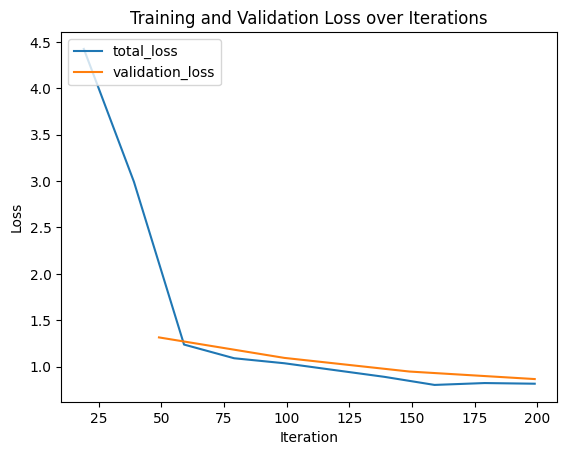

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = cfg.OUTPUT_DIR

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# Check if 'total_loss' key exists before accessing it
total_loss_data = [(x['iteration'], x['total_loss']) for x in experiment_metrics if 'total_loss' in x]

# Check if 'validation_loss' key exists before accessing it
validation_loss_data = [(x['iteration'], x['validation_loss']) for x in experiment_metrics if 'validation_loss' in x]

# Plotting
if total_loss_data:
    plt.plot(*zip(*total_loss_data), label='total_loss')

if validation_loss_data:
    plt.plot(*zip(*validation_loss_data), label='validation_loss')

plt.legend(loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.show()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Morshed/models/output/tfevents'

<IPython.core.display.Javascript object>

In [ ]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = cfg.OUTPUT_DIR
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# for inferenece please run the train config part first
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/27 06:10:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/Output/model_final.pth ...


Verify segmentation on random validation images

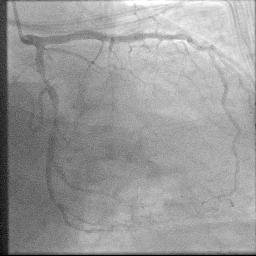

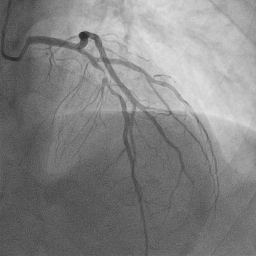

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 2):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("arcade_stenosis_val3", output_dir="/content/Output")
val_loader = build_detection_test_loader(cfg, "arcade_stenosis_val3")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/27 06:11:04 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/27 06:11:04 d2.evaluation.coco_evaluation]: Trying to convert 'arcade_stenosis_val3' to COCO format ...
[12/27 06:11:04 d2.data.datasets.coco]: Converting annotations of dataset 'arcade_stenosis_val3' to COCO format ...)


KeyError: ignored

**Load a new image and segment it.**

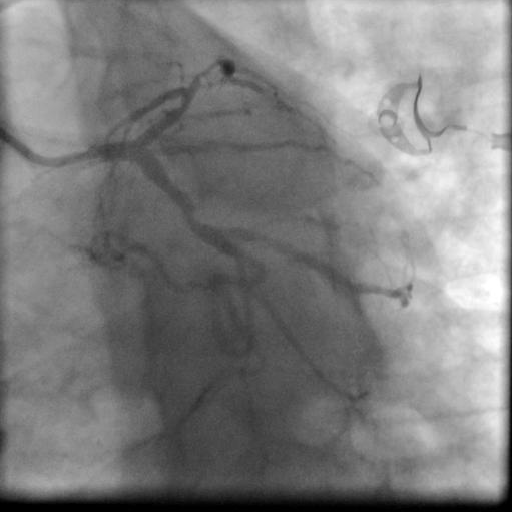

In [ ]:
new_im = cv2.imread("/content/arcade_dataset_phase_1_with_val/stenosis_dataset/val/images/107.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

Segmentation of all images completed.


**Saving binary (actually multinary) images for each class for further processing.**

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/val/images"

# Output directory where the segmented images will be saved
output_directory = "/content/instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


IndexError: ignored